# Use best model for predictions and interpret results

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import label_binarize # for ROC/AUC
import random

In [2]:
loaded_model = load_model(r"D:\cancer\checkpoints\best_weights.h5")

In [3]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    'D:/cancer/organized/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation: data in the order the labels are provided.
)


Found 2003 images belonging to 7 classes.


In [4]:
predictions = loaded_model.predict(test_generator, steps=len(test_generator), verbose=1)

63/63 [==============================] - 64s 1s/step


In [5]:
# get highest probability class
predicted_classes = np.argmax(predictions, axis=1)

In [6]:
# array of integers, where each integer corresponds to the true class index of each sample
true_classes = test_generator.classes

In [7]:
# get string class names by swapping keys and vals
label_map = dict((v,k) for k,v in test_generator.class_indices.items())
predicted_labels = [label_map[k] for k in predicted_classes]

In [8]:
label_map

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

## Confusion Matrix

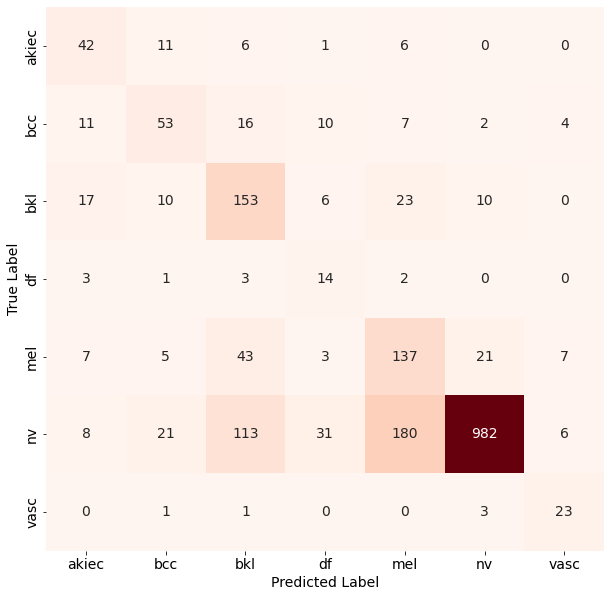

In [9]:
# Extract class labels in the correct order
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap=plt.cm.Reds, 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            annot_kws={"size": 14},
            cbar=False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

### Recall

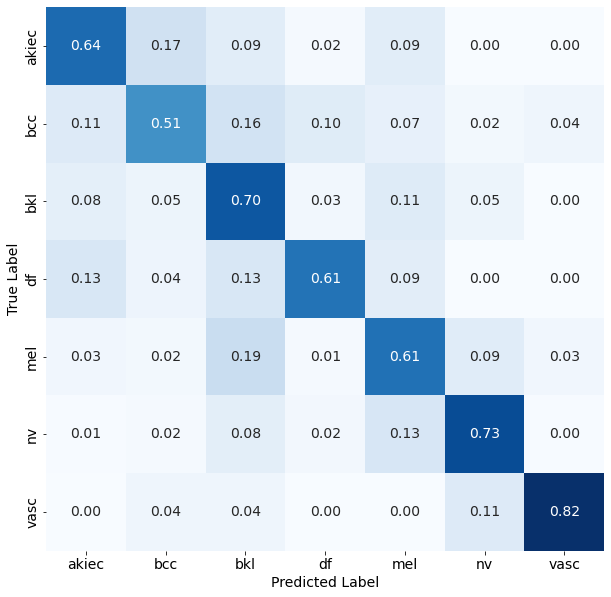

In [10]:
# Extract class labels in the correct order
class_labels = list(test_generator.class_indices.keys())

# row-wise normalization
cmn = confusion_matrix(true_classes, predicted_classes, normalize='true')

plt.figure(figsize=(10, 10))

sns.heatmap(cmn, 
            annot=True, 
            fmt=".2f", 
            cmap=plt.cm.Blues, 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar=False,
            annot_kws={"size": 14})


plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

plt.show()

In [11]:
# check
print("Row-wise sum:")
print(np.sum(cmn, axis=1))
print("Column-wise sum:")
print(np.sum(cmn, axis=0))

Row-wise sum:
[1. 1. 1. 1. 1. 1. 1.]
Column-wise sum:
[0.98857594 0.8441659  1.38811869 0.7849018  1.09942757 0.99868217
 0.89612793]


### Precision

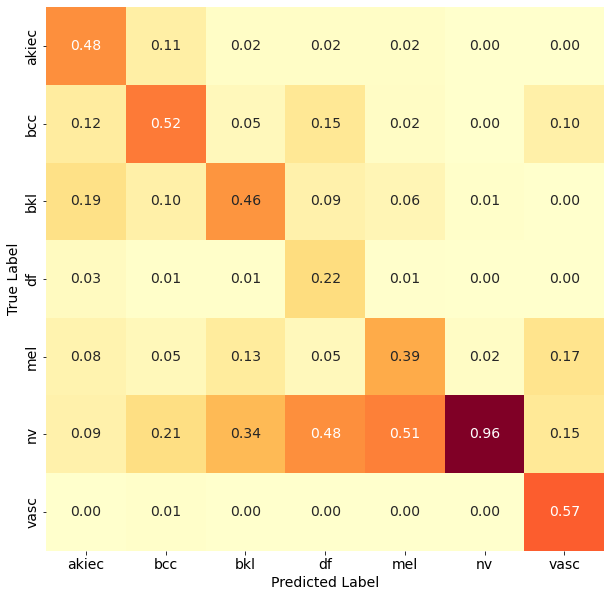

In [12]:
# Extract class labels in the correct order
class_labels = list(test_generator.class_indices.keys())

# row-wise normalization
cmn = confusion_matrix(true_classes, predicted_classes, normalize='pred')

plt.figure(figsize=(10, 10))

sns.heatmap(cmn, 
            annot=True, 
            fmt=".2f", 
            cmap=plt.cm.YlOrRd, 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar=False,
            annot_kws={"size": 14})


plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

plt.show()

## Classification Report

In [13]:
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

       akiec       0.48      0.64      0.55        66
         bcc       0.52      0.51      0.52       103
         bkl       0.46      0.70      0.55       219
          df       0.22      0.61      0.32        23
         mel       0.39      0.61      0.47       223
          nv       0.96      0.73      0.83      1341
        vasc       0.57      0.82      0.68        28

    accuracy                           0.70      2003
   macro avg       0.51      0.66      0.56      2003
weighted avg       0.79      0.70      0.73      2003



## ROC Curve and AUC (For multiclass)
- One-vs-Rest
- FPR vs TPR for different Thresholds

In [14]:
predictions[0]

array([2.1037252e-01, 1.2978873e-01, 1.3942675e-02, 5.5069574e-03,
       6.3244551e-01, 7.9362830e-03, 7.3131673e-06], dtype=float32)

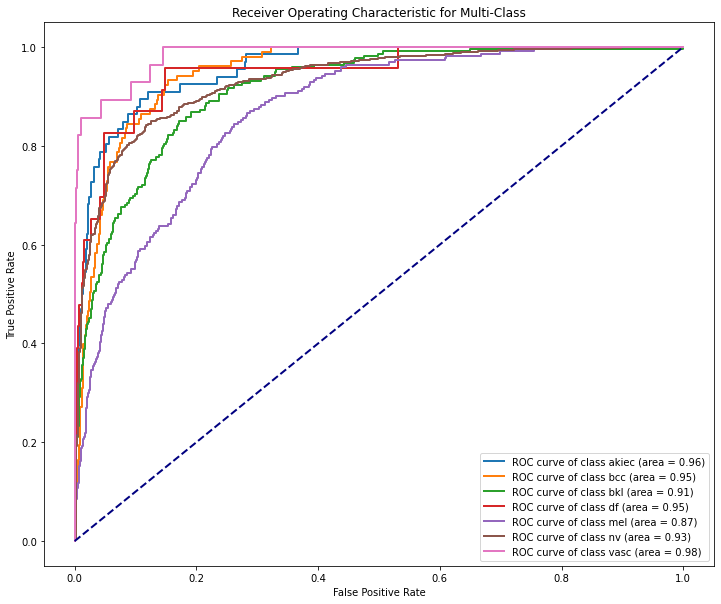

In [15]:
# Convert true labels into one-hot encoded format, looked at class is 1, rest is 0
y_true_onehot = label_binarize(true_classes, classes=np.arange(len(class_labels)))

# Store predicted probabilities for each class
y_pred_prob = predictions

# Initialize fig
plt.figure(figsize=(12, 10))

# For each class, compute and plot the ROC curve
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {class_labels[i]} (area = {roc_auc:.2f})')

# Plot random line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

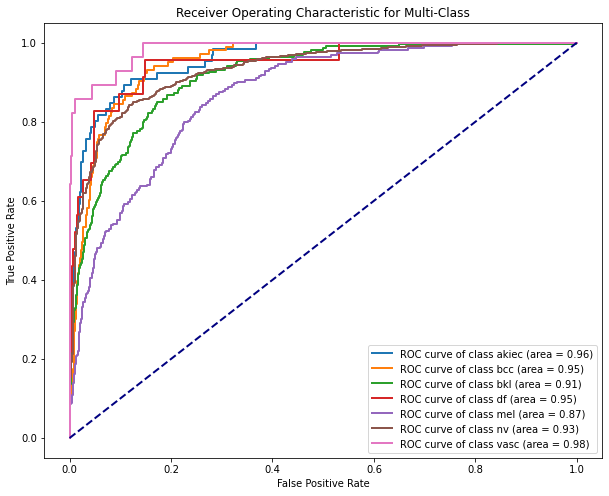

   Class  Optimal Threshold
0  akiec           0.059010
1    bcc           0.031202
2    bkl           0.231308
3     df           0.039550
4    mel           0.214288
5     nv           0.161028
6   vasc           0.005378


In [16]:
# Convert true labels into one-hot encoded format
y_true_onehot = label_binarize(true_classes, classes=np.arange(len(class_labels)))

# Initialize a dictionary to store optimal thresholds for each class
optimal_thresholds = {}

# Initialize a figure
plt.figure(figsize=(10, 8))

# For each class, compute and plot the ROC curve
for i in range(len(class_labels)):
    fpr, tpr, thresholds = roc_curve(y_true_onehot[:, i], predictions[:, i])
    roc_auc1 = auc(fpr, tpr)
    
    # Find the best threshold: the one that minimizes |(1 - TPR) - FPR|
    optimal_idx = np.argmin(np.abs((1 - tpr) - fpr))
    optimal_threshold = thresholds[optimal_idx]
    
    # Store the optimal threshold for this class
    optimal_thresholds[class_labels[i]] = optimal_threshold
    
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {class_labels[i]} (area = {roc_auc1:.2f})')

# Plot random line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

# Convert the dictionary to a Pandas DataFrame and display it
optimal_thresholds_df = pd.DataFrame(list(optimal_thresholds.items()), columns=['Class', 'Optimal Threshold'])
print(optimal_thresholds_df)



## Class Frequencies

In [17]:
import pandas as pd
df = pd.read_csv(r"D:\cancer\HAM10000_metadata.csv")

In [18]:
df.dx.value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

In [19]:
# Convert to Pandas Series
predicted_series = pd.Series(predicted_labels)

# Get normalized value counts
predicted_value_counts = predicted_series.value_counts(normalize=True)

In [20]:
# Convert true_classes to their corresponding labels
true_labels = [label_map[k] for k in true_classes]

# Convert to Pandas Series
true_series = pd.Series(true_labels)

# Get normalized value counts
true_value_counts = true_series.value_counts(normalize=True)

In [21]:
dx_mapping = {
    "nv": "Melanocytic nevus",
    "mel": "Melanoma",
    "bkl": "Benign keratosis-like lesion",
    "bcc": "Basal cell carcinoma",
    "akiec": "Actinic keratosis",
    "vasc": "Vascular lesion",
    "df": "Dermatofibroma"
}


# Create a DataFrame to hold both true and predicted value counts
df_plot = pd.DataFrame({
    'True': true_value_counts,
    'Predicted': predicted_value_counts
}).fillna(0).reset_index().rename(columns={'index': 'dx'})

# Map the dx values
df_plot['Diagnosis'] = df_plot['dx'].map(dx_mapping)

# Melt the DataFrame to long-form for easier plotting
df_melted = df_plot.melt(id_vars=['Diagnosis'], value_vars=['True', 'Predicted'], 
                         var_name='Type', value_name='Normalized Frequency')


In [22]:
df_melted

Diagnosis       Type  Normalized Frequency
0              Actinic keratosis       True              0.032951
1           Basal cell carcinoma       True              0.051423
2   Benign keratosis-like lesion       True              0.109336
3                 Dermatofibroma       True              0.011483
4                       Melanoma       True              0.111333
5              Melanocytic nevus       True              0.669496
6                Vascular lesion       True              0.013979
7              Actinic keratosis  Predicted              0.043934
8           Basal cell carcinoma  Predicted              0.050924
9   Benign keratosis-like lesion  Predicted              0.167249
10                Dermatofibroma  Predicted              0.032451
11                      Melanoma  Predicted              0.177234
12             Melanocytic nevus  Predicted              0.508238
13               Vascular lesion  Predicted              0.019970

In [23]:
fig = px.bar(
    df_melted,
    x='Diagnosis',
    y='Normalized Frequency',
    color='Type',
    barmode='group',
    title='True vs Predicted Class Frequencies',
    labels={'Normalized Frequency': 'Normalized Frequency', 'Diagnosis': 'Diagnosis'}
)

# Update x and y axis labels
fig.update_xaxes(title_text='Diagnosis')
fig.update_yaxes(title_text='Normalized Frequency')
fig.update_layout(legend_title_text='Type')

fig.show()

## Manual Interpretation of bad preds

In [24]:
# DataFrame w filenames, true classes, and predicted classes
result_df = pd.DataFrame({
    'Filename': test_generator.filenames,
    'True_Class': true_classes,
    'Predicted_Class': predicted_classes
})

# Convert numerical class to labels
result_df['True_Label'] = result_df['True_Class'].map(label_map)
result_df['Predicted_Label'] = result_df['Predicted_Class'].map(label_map)

# Add a indicator
result_df['Prediction_Correct'] = result_df.apply(lambda row: 'Good' if row['True_Class'] == row['Predicted_Class'] else 'Bad', axis=1)

# Col for prediction confidence
result_df['Prediction_Confidence'] = predictions[np.arange(len(predictions)), predicted_classes]

In [25]:
result_df

Filename  True_Class  Predicted_Class True_Label  \
0     akiec\ISIC_0024372.jpg           0                4      akiec   
1     akiec\ISIC_0024710.jpg           0                1      akiec   
2     akiec\ISIC_0024763.jpg           0                0      akiec   
3     akiec\ISIC_0024925.jpg           0                1      akiec   
4     akiec\ISIC_0024948.jpg           0                0      akiec   
...                      ...         ...              ...        ...   
1998   vasc\ISIC_0032745.jpg           6                6       vasc   
1999   vasc\ISIC_0033230.jpg           6                6       vasc   
2000   vasc\ISIC_0033762.jpg           6                6       vasc   
2001   vasc\ISIC_0033817.jpg           6                6       vasc   
2002   vasc\ISIC_0034196.jpg           6                6       vasc   

     Predicted_Label Prediction_Correct  Prediction_Confidence  
0                mel                Bad               0.632446  
1                bcc                Bad               0.875833  
2              akiec               Good               0.654648  
3                bcc                Bad               0.419105  
4              akiec               Good               0.594039  
...              ...                ...                    ...  
1998            vasc               Good               0.795272  
1999            vasc               Good               0.613331  
2000            vasc               Good               0.959165  
2001            vasc               Good               0.974113  
2002            vasc               Good               0.999075  

[2003 rows x 7 columns]

In [26]:
# Create a DataFrame from the groupby result
result_summary_df = result_df.groupby('True_Label').Prediction_Correct.value_counts(normalize=True).mul(100).reset_index(name='Count')
result_summary_df

True_Label Prediction_Correct      Count
0       akiec               Good  63.636364
1       akiec                Bad  36.363636
2         bcc               Good  51.456311
3         bcc                Bad  48.543689
4         bkl               Good  69.863014
5         bkl                Bad  30.136986
6          df               Good  60.869565
7          df                Bad  39.130435
8         mel               Good  61.434978
9         mel                Bad  38.565022
10         nv               Good  73.228934
11         nv                Bad  26.771066
12       vasc               Good  82.142857
13       vasc                Bad  17.857143

In [27]:
pivot_df = result_summary_df.pivot(index='True_Label', columns='Prediction_Correct', values='Count').fillna(0)
pivot_df.sort_values(by='Bad', ascending=False)

Prediction_Correct        Bad       Good
True_Label                              
bcc                 48.543689  51.456311
df                  39.130435  60.869565
mel                 38.565022  61.434978
akiec               36.363636  63.636364
bkl                 30.136986  69.863014
nv                  26.771066  73.228934
vasc                17.857143  82.142857

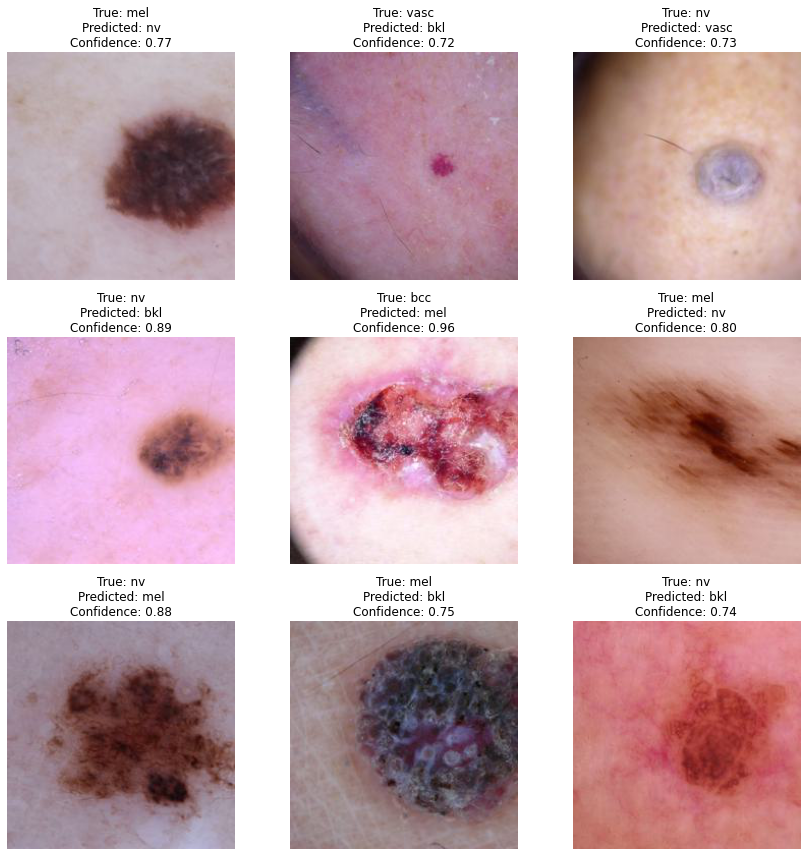

In [28]:
# Filter for bad predictions
bad_predictions_df = result_df[(result_df['Prediction_Correct'] == 'Bad') & (result_df.Prediction_Confidence > .7)]

# Randomly select some of these bad predictions
random_bad_indices = np.random.choice(bad_predictions_df.index, size=9, replace=False)
random_bad_predictions = bad_predictions_df.loc[random_bad_indices]

# Display the images along with labels and confidence
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, (idx, row) in enumerate(random_bad_predictions.iterrows()):
    ax = axes[i // 3, i % 3]
    
    # Load and display the image
    img_path = 'D:/cancer/organized/test/' + row['Filename']
    img = Image.open(img_path)
    ax.imshow(np.array(img))
    
    # Title with true label, predicted label, and prediction confidence
    title_str = f"True: {row['True_Label']}\nPredicted: {row['Predicted_Label']}\nConfidence: {row['Prediction_Confidence']:.2f}"
    ax.set_title(title_str)
    
    ax.axis('off')

plt.tight_layout()
plt.show()

## Show random images with predictions

1/1 [==============================] - 1s 1s/step


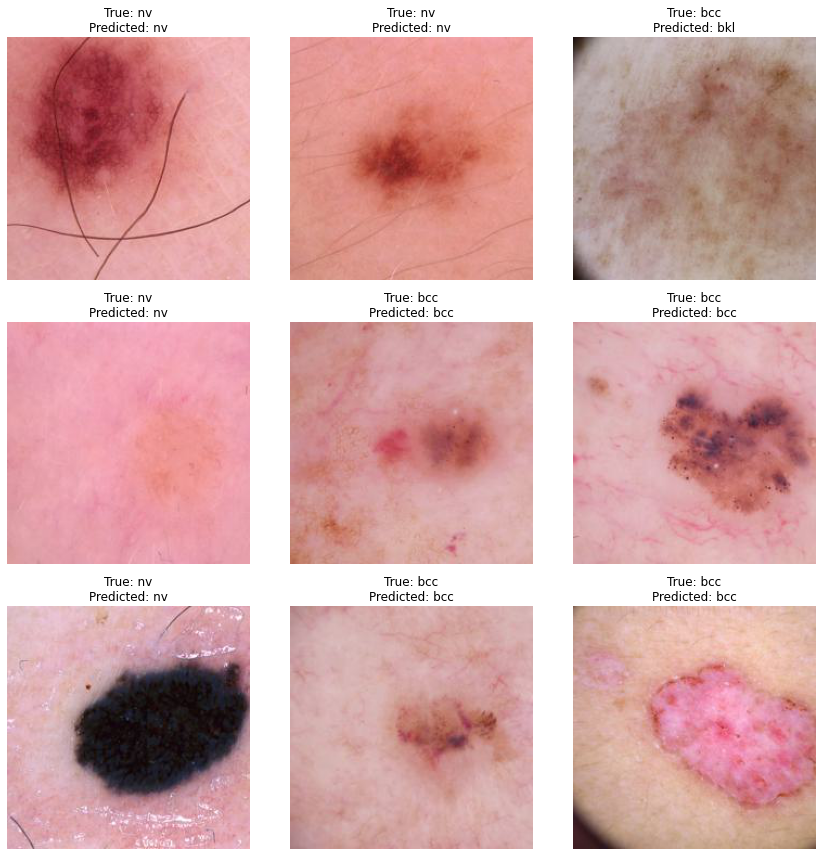

In [29]:
# Randomly select 9 image file paths and their labels from the test set
indices = np.random.choice(np.arange(len(test_generator.filenames)), size=9, replace=False)
image_paths = [test_generator.filepaths[i] for i in indices]
true_labels = [test_generator.classes[i] for i in indices]

# Load the original images without preprocessing
original_images = [Image.open(img_path) for img_path in image_paths]

# Preprocess images for prediction
preprocessed_images = [np.array(img.resize((224, 224))) for img in original_images]
preprocessed_images = preprocess_input(np.array(preprocessed_images))

predicted_probs = loaded_model.predict(preprocessed_images)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Display the original images with true and predicted labels
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(original_images[i])
    ax.set_title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()